# Playground

In [1]:
import pandas as pd
import numpy as np
import csv

from keras.utils import np_utils

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

image_width = 480
image_height = 480
image_depth = 1

num_classes = 3
categories_name = ['Background', 'Cosmic', 'Beam']
categories_value = [0, 1, 2]

batch_size = 10 

# Total: 10620
n_training = 30
training_feature_file = "input_files/training/feature_w.csv"
training_label_file = "input_files/training/label_w.csv"

# Total: 1320
n_validation = 30
validation_feature_file = "input_files/validation/feature_w.csv"
validation_label_file = "input_files/validation/label_w.csv"

# Total: 1330
n_testing = 30
testing_feature_file = "input_files/testing/feature_w.csv"
testing_label_file = "input_files/testing/label_w.csv"

Using TensorFlow backend.


In [2]:
def get_data(feature_file, label_file):
    with open(feature_file, "r") as csv1, open(label_file, "r") as csv2:
        reader1 = csv.reader(csv1)
        reader2 = csv.reader(csv2)
        # Skip the header row
        next(reader1)
        next(reader2)
        for row1, row2 in zip(reader1, reader2):
            array_row1 = np.array(row1, dtype=np.float)
            array_row2 = np.array(row2, dtype=np.int)
            yield array_row1, array_row2
            
def get_data_generator(feature_file, label_file, n_classes=num_classes, max_index=1, batch_size=1):
    with open(feature_file, "r") as csv1, open(label_file, "r") as csv2:
        reader1 = csv.reader(csv1)
        reader2 = csv.reader(csv2)

        i = 0
        n_col = 0
        while True:
            if(i == 0):
                # Skip the header row and count coln
                n_col = len(next(reader1))
                next(reader2)   
            if i + batch_size >= max_index:
                i = 0
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
            samples = np.zeros((len(rows), image_width, image_height, image_depth))
            targets = np.zeros((len(rows), image_width, image_height, n_classes))
            for j, row in enumerate(rows):
                for row1, row2 in zip(reader1, reader2):
                    array_row1 = np.array(row1, dtype=np.float)
                    samples[j,:,:,:] = preprocess_x(array_row1)
                    next(reader1)
                    
                    array_row2 = np.array(row2, dtype=np.int)
                    targets[j,:,:,:] = preprocess_y(array_row2, n_classes)
                    next(reader2)
                    
            yield (samples, targets)
            
def preprocess_x(x):
    # Feature is the adc values; scale it such that each value is between 0 and 1
    x_max = np.max(x)
    x = x/x_max
    return x.reshape(1, image_width, image_height, image_depth)

def preprocess_y(y, n_classes):
    return np_utils.to_categorical(y, num_classes=n_classes).reshape(1, image_width, image_height, n_classes)

(1, 480, 480, 1)
(480, 480)


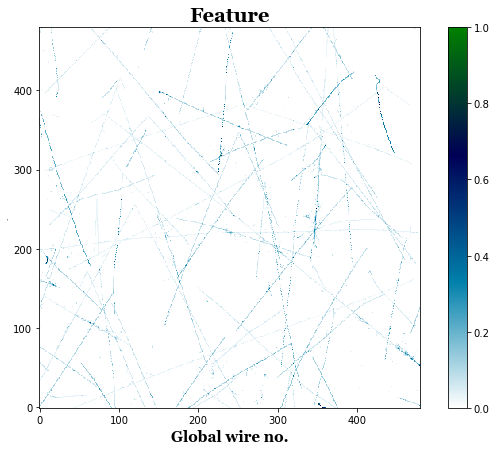

In [3]:
def plot_feature(feature_image):
    fig, ax0 = plt.subplots(1, 1, figsize=(10,7), facecolor='w')
    c0 = ax0.imshow(feature_image, cmap='ocean_r',interpolation='none', origin='lower',
                    vmin=0.0, vmax=1.0)
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Feature', fontsize=20,fontname='Georgia',fontweight='bold')

    plt.show()

my_gen = get_data_generator(feature_file=training_feature_file, 
                            label_file=training_label_file)
    
X, y = next(my_gen)
print(X.shape)
feature_image = X[0].reshape(image_width, image_height)
print(feature_image.shape)
plot_feature(feature_image)

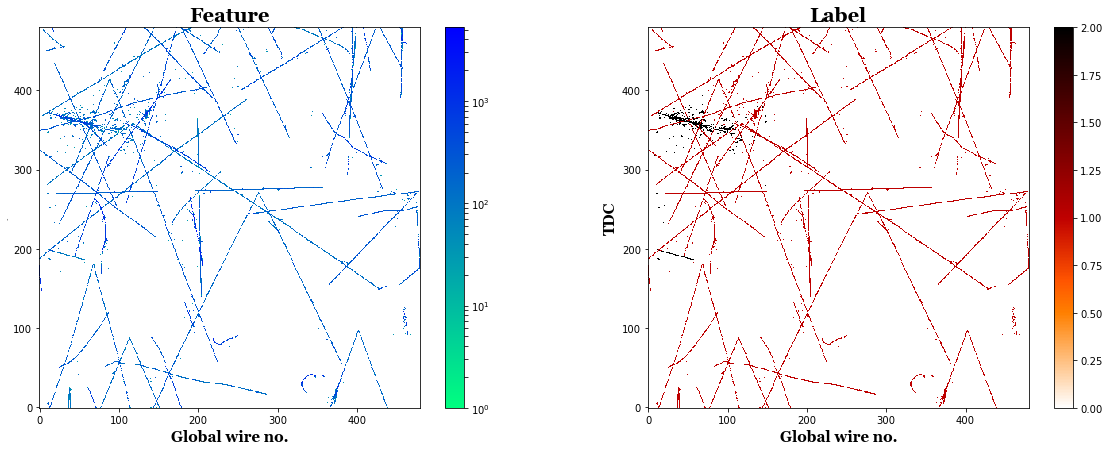

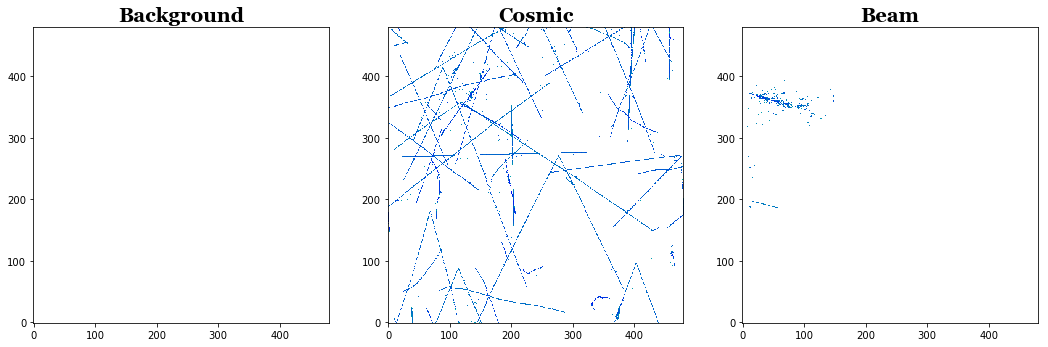

In [4]:
def plot_feature_label(feature_image, label_image, plot_name):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,7), facecolor='w')
    c0 = ax0.imshow(feature_image, cmap='winter_r',interpolation='none', origin='lower', 
                    norm=LogNorm(vmin=1.0, vmax=abs(feature_image).max()))
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Feature', fontsize=20,fontname='Georgia',fontweight='bold')

    c1= ax1.imshow(label_image,cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(label_image).min(), vmax=abs(label_image).max())
    fig.colorbar(c1, ax=ax1)
    ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_title('Label', fontsize=20, fontname='Georgia',fontweight='bold')

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

def plot_categories(feature_image, label_image, plot_name):
    fig, axes = plt.subplots(1, len(categories_value), figsize=(18,12), facecolor='w')
    for index, value in enumerate(categories_value):
        ax = axes[index]
        mask = (label_image == value)
        ax.imshow(feature_image*mask, cmap='winter_r',interpolation='none', origin='lower', 
                  norm=LogNorm(vmin=1.0, vmax=abs(feature_image).max()))
        ax.set_title(categories_name[index], fontsize=20, fontname='Georgia',fontweight='bold')
    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

iter_data = get_data(training_feature_file, training_label_file)
next(iter_data)
next(iter_data)
X, y = next(iter_data)

feature_image = X.reshape(image_width, image_height)
label_image = y.reshape(image_width, image_height)
plot_feature_label(feature_image, label_image, 'plots/W-PlaneFeatureAndLabel.pdf')
plot_categories(feature_image, label_image, 'plots/W-planeBkgCosmicBeam.pdf')

# Build U-net model

In [5]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # First layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # Vontracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid') (c9)        

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [6]:
import tensorflow as tf
from keras import backend as K

def dice_coef(y_true, y_pred, epsilon=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def intersection_over_union(y_true, y_pred, epsilon=1e-6):
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred)

    return ((2. * intersection + epsilon)/(union + epsilon))

def average_intersection_over_union(y_true, y_pred, n_classes=num_classes):
    """
    Average over classes and batch
    """
    total_iou = 0
    for c in range(n_classes):
        total_iou += intersection_over_union(y_true[:,:,:,c], y_pred[:,:,:,c])
            
    # Average over batch
    #total_iou = total_iou/y_pred.shape[0]

    # Average over classes
    return total_iou/n_classes

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

In [7]:
input_img = Input((image_height, image_width, image_depth))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer = 'adam', 
              loss=dice_coef_loss, 
              metrics = [average_intersection_over_union, dice_coef, "accuracy"])
#model.summary()

In [ ]:
# Stop training when a monitored quantity has stopped improving after 20 epochs
early_stop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

# Save the best model after every epoch
check_point = ModelCheckpoint(filepath='saved_models/model_and_weights.hdf5', 
                              save_best_only=True, verbose=1)

train_gen = get_data_generator(feature_file=training_feature_file, 
                               label_file=training_label_file, 
                               n_classes=num_classes, 
                               max_index=n_training, 
                               batch_size=batch_size)

val_gen = get_data_generator(feature_file=validation_feature_file, 
                             label_file=validation_label_file, 
                             n_classes=num_classes, 
                             max_index=n_validation, 
                             batch_size=batch_size)
    
test_gen = get_data_generator(feature_file=testing_feature_file, 
                              label_file=testing_label_file, 
                              n_classes=num_classes, 
                              max_index=n_testing, 
                              batch_size=batch_size)

In [ ]:
epochs = 10
n_workers = 1

history = model.fit_generator(train_gen, 
                              steps_per_epoch = n_training//batch_size,
                              epochs=epochs,
                              #validation_data=val_gen,
                              #validation_steps= n_validation//batch_size,
                              verbose=1,
                              callbacks=[check_point, early_stop, reduce_lr],
                              workers=n_workers)

Epoch 1/10


In [ ]:
# Summarize history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_accuracy.pdf', bbox_inches='tight')
plt.show()

'''
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Model mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_accuracy.pdf', bbox_inches='tight')
plt.show()
'''

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Load the model with the best classification accuracy on the validation set
model.load_weights('saved_models/model_and_weights.hdf5')

In [ ]:
#test_gen_pred = model.predict_generator(test_gen)
#print(test_gen_pred.shape)

In [ ]:
iter_data = iter(get_data(testing_feature_file, testing_label_file))
X, y = next(iter_data)
print(X.shape)
print(y.shape)
X_procesed = preprocess_x(X)
print(X_procesed.shape)
predictions = model.predict_on_batch(X_procesed)
print(predictions.shape)

y_reshaped = preprocess_y(y, num_classes)
print(y_reshaped.shape)

In [ ]:
ious = [0,0,0]
for i in range(len(ious)):
    ious[i] += intersection_over_union(y_reshaped[:,:,:,i], predictions[:,:,:,i])
    
n_preds = predictions.shape[0]

background = ious[0] / n_preds
cosmics = ious[1] / n_preds
beam = ious[2] / n_preds

average = (background + cosmics + beam)/3
print('number of validation samples intersection over the union evaulated on {}'.format(n_preds))
print('average intersection over union for background is {}'.format(background))
print('average intersection over union for cosmics is {}'.format(cosmics))
print('average intersection over union for beam is {}'.format(beam))

print('global average intersection over union is {}'.format(average))

In [ ]:
# our output class ID map will be num_classes x height x width in
# size, so we take the argmax to find the class label with the
# largest probability for each and every (x, y)-coordinate in the
# image
prediction_max = np.argmax(predictions, axis=3)
print(prediction_max.shape)

In [ ]:
def plot_feature_label_prediction(feature_image, label_image, prediction_image, plot_name):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5), facecolor='w')
    c0 = ax0.imshow(feature_image, cmap='winter_r',interpolation='none', origin='lower', 
                    norm=LogNorm(vmin=1.0, vmax=abs(feature_image).max()))
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Feature', fontsize=20,fontname='Georgia',fontweight='bold')

    c1= ax1.imshow(label_image,cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(label_image).min(), vmax=abs(label_image).max())
    fig.colorbar(c1, ax=ax1)
    ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_title('Label', fontsize=20, fontname='Georgia',fontweight='bold')

    c2= ax2.imshow(prediction_image, cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(prediction_image).min(), vmax=abs(prediction_image).max())
    fig.colorbar(c2, ax=ax2)
    ax2.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax2.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax2.set_title('Prediction', fontsize=20, fontname='Georgia',fontweight='bold')

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

def plot_data_prediction(data_image, prediction_image, plot_name):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,7), facecolor='w')
    c0 = ax0.imshow(data_image, cmap='winter_r',interpolation='none', origin='lower', 
                    norm=LogNorm(vmin=1.0, vmax=abs(data_image).max()))
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Data', fontsize=20,fontname='Georgia',fontweight='bold')

    c1= ax1.imshow(prediction_image, cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(prediction_image).min(), vmax=abs(prediction_image).max())
    fig.colorbar(c1, ax=ax1)
    ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_title('Prediction', fontsize=20, fontname='Georgia',fontweight='bold')

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

feature_image = X.reshape(image_width, image_height)
label_image = y.reshape(image_width, image_height)
prediction_image = prediction_max.reshape(image_width, image_height)
plot_feature_label_prediction(feature_image, label_image, prediction_image, 'plots/feature_label_prediction.pdf')

plot_data_prediction(feature_image, prediction_image, 'plots/data_prediction.pdf')